In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pubg-finish-placement-prediction/train_V2.csv
/kaggle/input/pubg-finish-placement-prediction/test_V2.csv
/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore
from scipy.stats import t
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV

In [12]:
train_df = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')
train_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [13]:
test_df = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/test_V2.csv')
test_df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.10,0,0,2,11,...,1503,2,4669.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,787.8,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.52,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.20,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2963.0,4,0


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [15]:
columns_to_drop = ['killPoints', 'rankPoints', 'winPoints', 'numGroups', 
                   'roadKills', 'teamKills', 'vehicleDestroys', 'groupId','damageDealt']


In [16]:
# 데이터프레임에 있는 열만 삭제
columns_to_drop = [col for col in columns_to_drop if col in train_df.columns]

# 열 삭제
train_df.drop(columns=columns_to_drop, inplace=True)

In [17]:
# 변경된 데이터프레임 확인
print(train_df.head())

               Id         matchId  assists  boosts  DBNOs  headshotKills  \
0  7f96b2f878858a  a10357fd1a4a91        0       0      0              0   
1  eef90569b9d03c  aeb375fc57110c        0       0      0              0   
2  1eaf90ac73de72  110163d8bb94ae        1       0      0              0   
3  4616d365dd2853  f1f1f4ef412d7e        0       0      0              0   
4  315c96c26c9aac  6dc8ff871e21e6        0       0      0              0   

   heals  killPlace  kills  killStreaks  longestKill  matchDuration  \
0      0         60      0            0         0.00           1306   
1      0         57      0            0         0.00           1777   
2      0         47      0            0         0.00           1318   
3      0         75      0            0         0.00           1436   
4      0         45      1            1        58.53           1424   

   matchType  maxPlace  revives  rideDistance  swimDistance  walkDistance  \
0  squad-fpp        28        0        

In [18]:
# winPlacePerc 열의 결측치를 평균 값으로 대체합니다.
mean_winPlacePerc = train_df['winPlacePerc'].mean()
train_df['winPlacePerc'] = train_df['winPlacePerc'].fillna(mean_winPlacePerc)

missing_values = train_df.isnull().sum()
print("대체된 데이터에서 결측치 수:\n", missing_values)

대체된 데이터에서 결측치 수:
 Id                 0
matchId            0
assists            0
boosts             0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
revives            0
rideDistance       0
swimDistance       0
walkDistance       0
weaponsAcquired    0
winPlacePerc       0
dtype: int64


In [19]:
missing_values = train_df[['killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration']].isnull().sum()
print("killPlace, kills, killStreaks, longestKill, matchDuration 열의 결측치 수:\n", missing_values)

killPlace, kills, killStreaks, longestKill, matchDuration 열의 결측치 수:
 killPlace        0
kills            0
killStreaks      0
longestKill      0
matchDuration    0
dtype: int64


In [20]:
train_df['total_distance'] = train_df['rideDistance'] + train_df['swimDistance'] + train_df['walkDistance']

In [21]:
b = train_df[(train_df['total_distance'] == 0) & ( train_df['winPlacePerc'] > 0.5)]
b = b[['Id','total_distance','kills','matchType','winPlacePerc','maxPlace']]

In [22]:
c = (b.groupby('matchType')["Id"].count() / train_df.groupby('matchType')['Id'].count())*100
c.round(2)

matchType
crashfpp             0.02
crashtpp              NaN
duo                  0.01
duo-fpp              0.01
flarefpp              NaN
flaretpp             0.04
normal-duo           3.02
normal-duo-fpp       0.86
normal-solo         10.43
normal-solo-fpp      9.04
normal-squad         7.36
normal-squad-fpp     3.45
solo                 0.44
solo-fpp             0.04
squad                0.02
squad-fpp            0.02
Name: Id, dtype: float64

In [23]:
train_df["total_distance"] = train_df["rideDistance"]+train_df["swimDistance"]+train_df["walkDistance"]
train_df.loc[train_df["total_distance"] == 0, "winPlacePerc"] = 0

In [24]:
train_df.loc[train_df["matchType"].str.contains("crash"), "matchType"] = "crash"
train_df.loc[train_df["matchType"].str.contains("flare"), "matchType"] = "flare"
train_df.loc[train_df["matchType"].str.contains("duo"), "matchType"] = "duo"
train_df.loc[train_df["matchType"].str.contains("solo"), "matchType"] = "solo"
train_df.loc[train_df["matchType"].str.contains("squad"), "matchType"] = "squad"

In [25]:
train_df["heal_boost"] = train_df["heals"]+train_df["boosts"]

In [26]:
enc = OneHotEncoder()
matchType_encoded = enc.fit_transform(train_df[["matchType"]])

encoded_df = pd.DataFrame(matchType_encoded.toarray(), columns=enc.get_feature_names_out(["matchType"]))

train_df.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

final_df = pd.concat([train_df.drop("matchType", axis=1), encoded_df], axis=1)

In [27]:
# 한 경기에서의 최대 킬 횟수가 참여자 수를 넘지 않는지 확인
max_kills_per_match = final_df.groupby('matchId')['kills'].max()
num_players_per_match = final_df.groupby('matchId')['Id'].count()

# 최대 킬 횟수가 참여자 수를 넘는 행 추출
invalid_matches = max_kills_per_match[max_kills_per_match > num_players_per_match].index

# 해당하는 행 삭제
final_df_cleaned = final_df[~train_df['matchId'].isin(invalid_matches)]

# 전처리 후 데이터 확인
print("전처리 전 데이터 개수:", len(final_df))
print("전처리 후 데이터 개수:", len(final_df_cleaned))

전처리 전 데이터 개수: 4446966
전처리 후 데이터 개수: 4444947


In [28]:
# train_df에서 kills와 total_distance 열 선택
selected_columns = ['kills', 'total_distance']
df_selected = final_df[selected_columns]

# Tukey 방법을 사용하여 이상치 식별 및 처리
def identify_outliers_tukey(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers

outliers = identify_outliers_tukey(df_selected)
outliers_sum = outliers.sum()
print("이상치의 총 수:", outliers_sum)

이상치의 총 수: kills             516699
total_distance    207666
dtype: int64


In [29]:
# 수치형 열만 선택
numeric_columns = df_selected.select_dtypes(include=['number']).columns

# 모든 열에 대해 이상치 식별
all_outliers = {}
for column in numeric_columns:
    outliers_column = identify_outliers_tukey(df_selected[column])
    all_outliers[column] = outliers_column

# 각 열의 이상치 총합 계산
total_outliers = {}
for column, outliers_column in all_outliers.items():
    total_outliers[column] = outliers_column.sum()

# 결과 출력
for column, total in total_outliers.items():
    print(f"{column} 열의 이상치 총 수: {total}")

kills 열의 이상치 총 수: 516699
total_distance 열의 이상치 총 수: 207666


In [30]:
# train_df에서 kills와 total_distance 열 선택
selected_columns = ['kills', 'total_distance']
df_selected = final_df[selected_columns]

# 결과 확인
print("Selected columns data:")
print(df_selected.head())

Selected columns data:
   kills  total_distance
0      0        244.8000
1      0       1445.0445
2      0        161.8000
3      0        202.7000
4      1         49.7500


In [31]:
# 모든 열을 선택하여 데이터프레임 가져오기
numeric_features = final_df.select_dtypes(include=['int64', 'float64'])

# 표준화 객체 생성
scaler = StandardScaler()

# 데이터 표준화
scaled_features = scaler.fit_transform(numeric_features)

# 표준화된 데이터를 데이터프레임으로 변환
scaled_df = pd.DataFrame(scaled_features, columns=numeric_features.columns)

# 결과 출력
print("표준화된 데이터:")
print(scaled_df)

표준화된 데이터:
          assists    boosts     DBNOs  headshotKills     heals  killPlace  \
0       -0.397257 -0.645129 -0.574191      -0.376680 -0.511252   0.451541   
1       -0.397257 -0.645129 -0.574191      -0.376680 -0.511252   0.342303   
2        1.301767 -0.645129 -0.574191      -0.376680 -0.511252  -0.021824   
3       -0.397257 -0.645129 -0.574191      -0.376680 -0.511252   0.997732   
4       -0.397257 -0.645129 -0.574191      -0.376680 -0.511252  -0.094649   
...           ...       ...       ...            ...       ...        ...   
4446961 -0.397257 -0.645129 -0.574191      -0.376680 -0.511252   0.961319   
4446962 -0.397257 -0.062308 -0.574191      -0.376680 -0.511252   0.779256   
4446963 -0.397257 -0.645129 -0.574191      -0.376680 -0.511252   0.670018   
4446964 -0.397257  1.686154  0.298605       1.284022  0.235021  -1.332682   
4446965 -0.397257  0.520513 -0.574191      -0.376680 -0.138116  -1.077793   

            kills  killStreaks  longestKill  matchDuration  ...  

Descriptive statistics:
              kills  total_distance
count  4.446966e+06    4.446966e+06
mean   9.247833e-01    1.764843e+03
std    1.558445e+00    2.183117e+03
min    0.000000e+00    0.000000e+00
25%    0.000000e+00    1.581000e+02
50%    0.000000e+00    7.882000e+02
75%    1.000000e+00    2.728447e+03
max    7.200000e+01    4.127010e+04


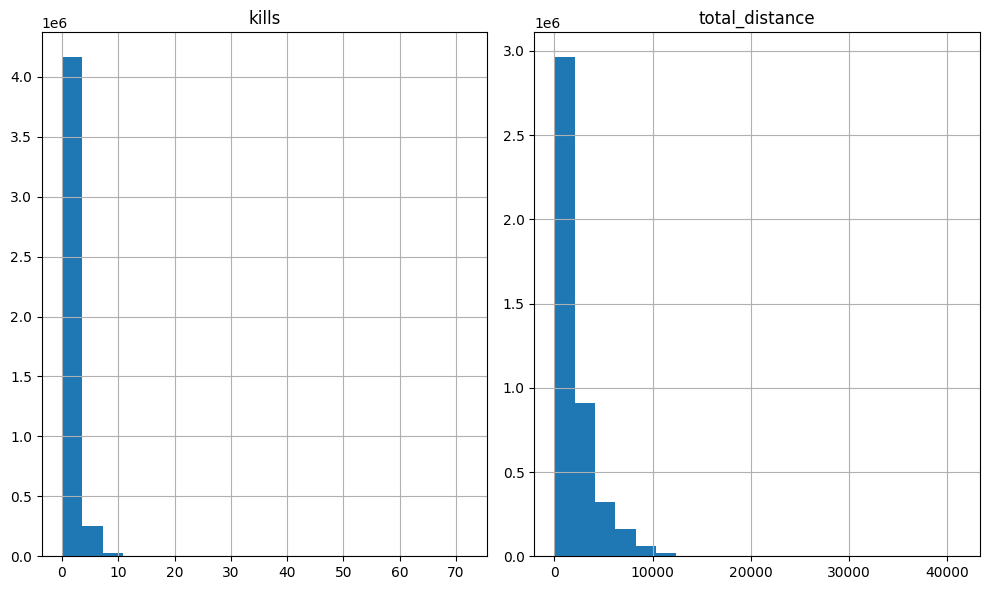

Correlation matrix:
                   kills  total_distance
kills           1.000000        0.282473
total_distance  0.282473        1.000000


In [32]:
# 'kills'와 'total_distance' 열 선택
selected_columns = ['kills', 'total_distance']
df_selected = final_df[selected_columns]

# 각 열의 기술 통계량 확인
print("Descriptive statistics:")
print(df_selected.describe())

# 각 열의 분포 시각화
df_selected.hist(bins=20, figsize=(10, 6))
plt.tight_layout()
plt.show()

# 상관 관계 분석
correlation_matrix = df_selected.corr()
print("Correlation matrix:")
print(correlation_matrix)

In [33]:
# 'matchType' 열을 제외하고 수치형 열만 선택
numeric_columns = [col for col in train_df.columns if col != 'matchType' and final_df[col].dtype != 'object']
df_selected = final_df[numeric_columns]

# 상관 관계 분석
correlation_matrix = df_selected.corr()
print("Correlation matrix:")
print(correlation_matrix)

Correlation matrix:
                  assists    boosts     DBNOs  headshotKills     heals  \
assists          1.000000  0.307683  0.301057       0.198289  0.228556   
boosts           0.307683  1.000000  0.358907       0.334661  0.535854   
DBNOs            0.301057  0.358907  1.000000       0.469923  0.265485   
headshotKills    0.198289  0.334661  0.469923       1.000000  0.199918   
heals            0.228556  0.535854  0.265485       0.199918  1.000000   
killPlace       -0.290062 -0.554844 -0.555289      -0.469829 -0.386032   
kills            0.319690  0.502024  0.707848       0.674275  0.311781   
killStreaks      0.243471  0.405327  0.646872       0.512882  0.270412   
longestKill      0.261425  0.423290  0.451422       0.447261  0.263278   
matchDuration   -0.019450  0.072108 -0.014485      -0.017657  0.108901   
maxPlace        -0.147916 -0.013686 -0.267709       0.009211 -0.064759   
revives          0.198320  0.253125  0.300999       0.150145  0.236680   
rideDistance     0

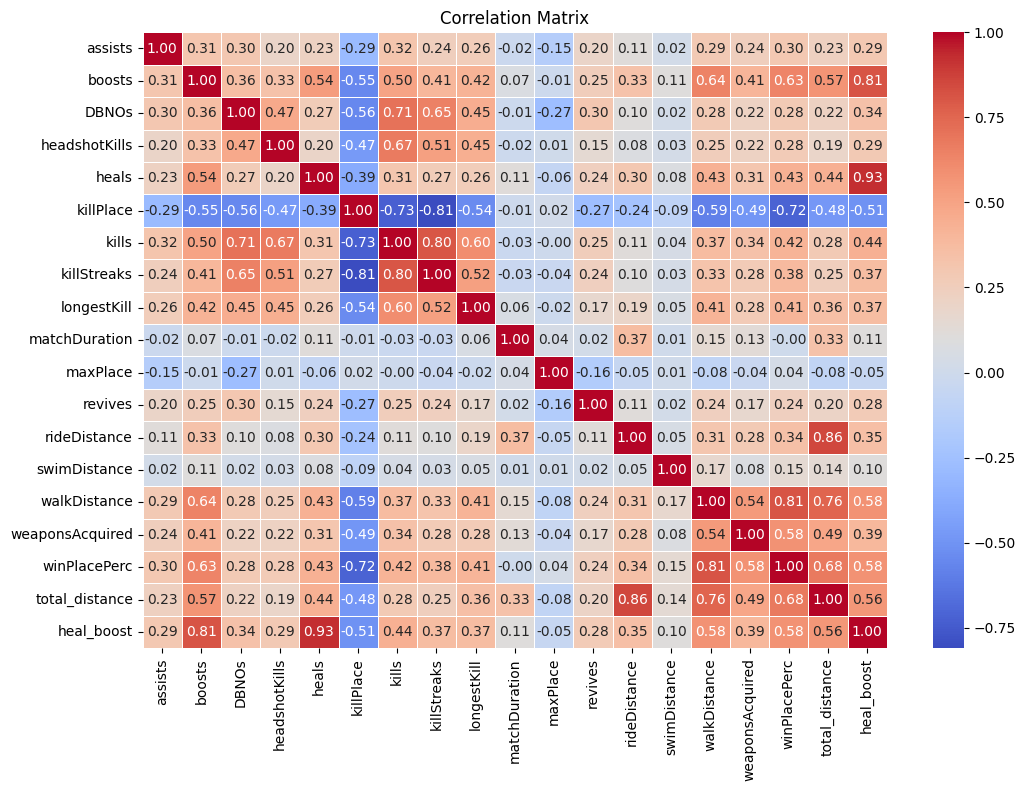

In [34]:
# 상관 행렬을 시각화합니다.
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [35]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 26 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   matchId          object 
 2   assists          int64  
 3   boosts           int64  
 4   DBNOs            int64  
 5   headshotKills    int64  
 6   heals            int64  
 7   killPlace        int64  
 8   kills            int64  
 9   killStreaks      int64  
 10  longestKill      float64
 11  matchDuration    int64  
 12  maxPlace         int64  
 13  revives          int64  
 14  rideDistance     float64
 15  swimDistance     float64
 16  walkDistance     float64
 17  weaponsAcquired  int64  
 18  winPlacePerc     float64
 19  total_distance   float64
 20  heal_boost       int64  
 21  matchType_crash  float64
 22  matchType_duo    float64
 23  matchType_flare  float64
 24  matchType_solo   float64
 25  matchType_squad  float64
dtypes: float64(11), int64(13), object(2)
memor

In [36]:
for column in final_df.columns:
    data_type = final_df[column].dtype
    print(f"{column}: {data_type}")

# 범주형 열과 연속형 열을 분류
categorical_columns = []
continuous_columns = []

for column in final_df.columns:  # train_df.columns가 아닌 final_df.columns를 사용해야 합니다.
    if final_df[column].dtype == 'object' or final_df[column].dtype.name == 'category':
        categorical_columns.append(column)
    elif final_df[column].dtype in ['int64', 'float64']:
        continuous_columns.append(column)

print("\n범주형 열:")
print(categorical_columns)
print("\n연속형 열:")
print(continuous_columns)

Id: object
matchId: object
assists: int64
boosts: int64
DBNOs: int64
headshotKills: int64
heals: int64
killPlace: int64
kills: int64
killStreaks: int64
longestKill: float64
matchDuration: int64
maxPlace: int64
revives: int64
rideDistance: float64
swimDistance: float64
walkDistance: float64
weaponsAcquired: int64
winPlacePerc: float64
total_distance: float64
heal_boost: int64
matchType_crash: float64
matchType_duo: float64
matchType_flare: float64
matchType_solo: float64
matchType_squad: float64

범주형 열:
['Id', 'matchId']

연속형 열:
['assists', 'boosts', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'revives', 'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired', 'winPlacePerc', 'total_distance', 'heal_boost', 'matchType_crash', 'matchType_duo', 'matchType_flare', 'matchType_solo', 'matchType_squad']


In [37]:
# 종속 변수 설정
dependent_variable = 'winPlacePerc'

# 독립 변수 설정 (제외할 열)
excluded_columns = ['Id', 'matchId', dependent_variable]

# 독립 변수 선택
independent_variables = [col for col in final_df.columns if col not in excluded_columns]

# 결과 확인
print("독립 변수:")
print(independent_variables)
print("\n종속 변수:")
print(dependent_variable)

독립 변수:
['assists', 'boosts', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'revives', 'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired', 'total_distance', 'heal_boost', 'matchType_crash', 'matchType_duo', 'matchType_flare', 'matchType_solo', 'matchType_squad']

종속 변수:
winPlacePerc


In [38]:
# 표준화 객체 생성
scaler = StandardScaler()

# 연속형 변수들 선택
continuous_columns = ['assists', 'boosts', 'DBNOs', 'headshotKills', 'heals', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'matchDuration', 'maxPlace', 'revives', 'rideDistance', 'swimDistance', 'walkDistance', 'weaponsAcquired', 'total_distance', 'heal_boost', 'matchType_crash', 'matchType_duo', 'matchType_flare', 'matchType_solo', 'matchType_squad']

# 연속형 변수들을 표준화
final_df[continuous_columns] = scaler.fit_transform(final_df[continuous_columns])

# 결과 확인
print(final_df.head())

               Id         matchId   assists    boosts     DBNOs  \
0  7f96b2f878858a  a10357fd1a4a91 -0.397257 -0.645129 -0.574191   
1  eef90569b9d03c  aeb375fc57110c -0.397257 -0.645129 -0.574191   
2  1eaf90ac73de72  110163d8bb94ae  1.301767 -0.645129 -0.574191   
3  4616d365dd2853  f1f1f4ef412d7e -0.397257 -0.645129 -0.574191   
4  315c96c26c9aac  6dc8ff871e21e6 -0.397257 -0.645129 -0.574191   

   headshotKills     heals  killPlace     kills  killStreaks  ...  \
0       -0.37668 -0.511252   0.451541 -0.593402    -0.765087  ...   
1       -0.37668 -0.511252   0.342303 -0.593402    -0.765087  ...   
2       -0.37668 -0.511252  -0.021824 -0.593402    -0.765087  ...   
3       -0.37668 -0.511252   0.997732 -0.593402    -0.765087  ...   
4       -0.37668 -0.511252  -0.094649  0.048264     0.641439  ...   

   walkDistance  weaponsAcquired  winPlacePerc  total_distance  heal_boost  \
0     -0.768416        -1.083021        0.4444       -0.696272   -0.638419   
1      0.236403         0.

In [39]:
# 검증 데이터셋에 해당하는 인덱스 계산
valid_index = int(len(final_df) * 0.8)  # 전체 데이터 중 80%를 학습 데이터로 사용하고 20%를 검증 데이터로 사용

# 검증 데이터셋에 대한 실제 종속 변수 값
y_valid_actual = final_df.iloc[valid_index:][dependent_variable]

In [40]:
# 데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(final_df[independent_variables], final_df[dependent_variable], test_size=0.2, random_state=42)

# LightGBM 모델 정의
model = lgb.LGBMRegressor()

# 모델 학습
model.fit(X_train, y_train)

# 검증 데이터에 대한 예측
y_pred = model.predict(X_valid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.262105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1988
[LightGBM] [Info] Number of data points in the train set: 3557572, number of used features: 23
[LightGBM] [Info] Start training from score 0.471997


In [41]:
# 검증 데이터에 대한 MSE 계산
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.007036914242760145


In [42]:
# 이동 거리가 0이고 무기를 주운 횟수가 0이며 킬이 0인 레코드의 인덱스 찾기
a = final_df.loc[(final_df["walkDistance"] == 0) & (final_df["weaponsAcquired"] == 0) & (final_df["kills"] == 0)].index

# 해당 인덱스를 사용하여 행 삭제
final_df.drop(index=a, inplace=True)

In [ ]:
하이퍼 파라미터 찾을려면 랜덤서 킬이 0 매치안에 있는 사람보다 많은 건 날리자 다 0인데 우승 한 
사람들도 날리지 (최병찬 님이 주신 코드로 24개 드랍) 
샘플링이 무엇일까 ? 4분의 1정도만 나누고 돌려보자 
분석 방향 모델링 하면 성능이 나오고 그중에서 결론에서 가장 좋은 모델은 이거였다 + 전처리 방식을 
어떻게 하는 것이 효과가 좋았다 

In [44]:
# LightGBM 모델 정의
model = lgb.LGBMRegressor()

# 탐색할 하이퍼파라미터 공간 정의
param_grid = {
    'num_leaves': [31, 50, 100],  # 트리의 잎 노드 수
    'learning_rate': [0.01, 0.05, 0.1],  # 학습률
    'n_estimators': [100, 200, 300],  # 트리의 개수
    'max_depth': [-1, 10, 20],  # 트리의 최대 깊이
    'min_child_samples': [20, 50, 100],  # 리프 노드가 되기 위한 최소한의 데이터 수
}

# 랜덤 서치 객체 생성
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3, random_state=42)

# 모델 훈련
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", random_search.best_params_)

# 최적의 모델
best_model = random_search.best_estimator_

# 검증 데이터에 대한 예측
y_pred = best_model.predict(X_valid)

# 검증 데이터에 대한 MSE 계산
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error:", mse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.366778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1990
[LightGBM] [Info] Number of data points in the train set: 2371714, number of used features: 23
[LightGBM] [Info] Start training from score 0.471998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.319644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1987
[LightGBM] [Info] Number of data points in the train set: 2371715, number of used features: 23
[LightGBM] [Info] Start training from score 0.472033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.324377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1989
[LightGBM] [Info] Number of data points in the train set: 2371715, number of used features: 23
[LightGBM] [Info] Sta

KeyboardInterrupt: 